In [3]:
%reset -s -f

In [9]:
%pip install torch seaborn pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 9.6 MB/s eta 0:00:00:00:010:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [10]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

In [11]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
# rgdppc means real gdp per capita for the year 2000
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

In [15]:
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
df

,cont_africa,rugged,rgdppc_2000
2,1,0.858,2.013917
4,0,3.427,2.106197
7,0,0.769,2.295889
8,0,0.775,2.241457
9,0,2.688,2.053142
...,...,...,...
229,0,1.677,2.138753
230,0,2.323,1.897497
231,1,1.761,2.213808
232,1,0.533,1.894855


In [16]:
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

[Text(0.5, 0, 'Ruggedness Index'),
 Text(0, 0.5, 'log GDP per capita (2000)'),
 Text(0.5, 1.0, 'African Nations')]

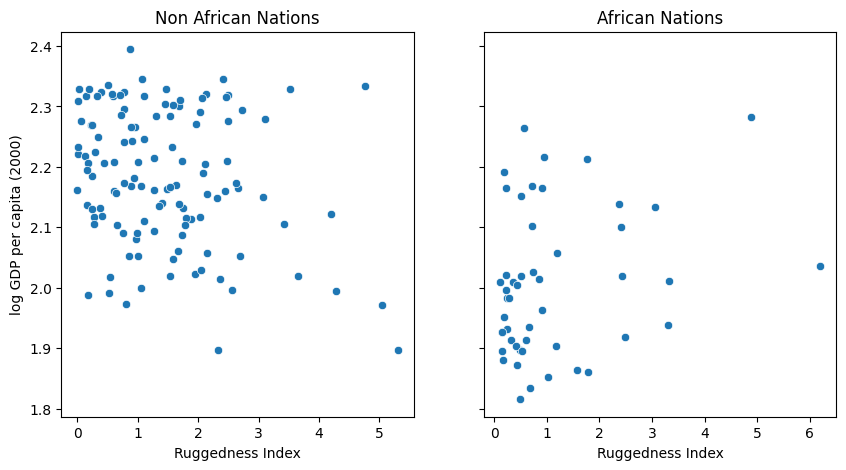

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]

sns.scatterplot(
    x=non_african_nations["rugged"], y=non_african_nations["rgdppc_2000"], ax=ax[0]
)
ax[0].set(
    xlabel="Ruggedness Index",
    ylabel="log GDP per capita (2000)",
    title="Non African Nations",
)

sns.scatterplot(x=african_nations["rugged"], y=african_nations["rgdppc_2000"], ax=ax[1])
ax[1].set(
    xlabel="Ruggedness Index",
    ylabel="log GDP per capita (2000)",
    title="African Nations",
)

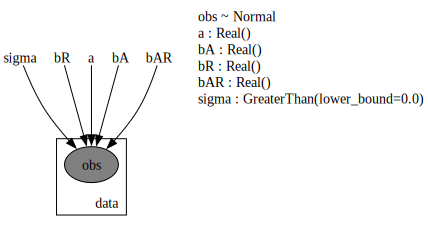

In [22]:
# mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

import pyro.distributions as dist
import pyro.distributions.constraints as constraints


def simple_model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.param("a", lambda: torch.randn(()))
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

    mean = (
        a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    )

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)


pyro.render_model(
    simple_model,
    model_args=(is_cont_africa, ruggedness, log_gdp),
    render_distributions=True,
    render_params=True,
)

In [27]:
# Let's use condition to simplify the previous model, thus removing the need to pass in log_gdp
def simpler_model(is_cont_africa, ruggedness):
    a = pyro.param("a", lambda: torch.randn(()))
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

    mean = (
        a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    )

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma))


# With this syntax, we tell Pyro that the obs variable is conditioned to the observed data in log_gdp
conditioned_model = pyro.condition(simpler_model, data={"obs": log_gdp})

# It is equivalent to this
# conditioned_model = functools.partial(simple_model, log_gdp=log_gdp)

pyro.render_model(
    simple_model,
    model_args=(is_cont_africa, ruggedness, log_gdp),
    render_distributions=True,
    render_params=True,
)

tensor(0.4373)